## Get data

In [1]:
# Clustering questions from 'Jeden z dziesięciu',
# data: https://github.com/poleval/2021-question-answering

import pandas as pd
import requests
from io import StringIO


url = "https://raw.githubusercontent.com/poleval/2021-question-answering/main/test-A/in.tsv"

response = requests.get(url)
response.raise_for_status()

df = pd.read_csv(StringIO(response.text), sep='\t', index_col=0)

print(df.head())

Empty DataFrame
Columns: []
Index: [W którym państwie została ogłoszona „Deklaracja praw człowieka i obywatela”?, Która kawa zawiera alkohol: po turecku czy po irlandzku?, W którym mieście zmarł Sławomir Mrożek?, Jak nazywał się autor powieści „Wierna rzeka”?, W którym polskim mieście wybrzeża znajduje się Fontanna Neptuna?]


In [8]:
questions = list(df.index)
print(f"Number of questions {len(questions) = }\n")
questions[-5:]

Number of questions len(questions) = 2499



['Na którym kontynencie założono pierwszy Park Narodowy?',
 'Czy Szwajcaria należy do ONZ?',
 'Jak nazywał się król Prus, inicjator I rozbioru Polski?',
 'Czy Anna Karenina, bohaterka powieści Lwa Tołstoja, była mężatką?',
 'Wirtuozem którego instrumentu jest Nigel Kennedy?']

## Generate embeddings

In [4]:
from sentence_transformers import SentenceTransformer
import numpy as np


# small multilingual model (larger are better)
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
# Generuj embeddingi
embeddings = model.encode(questions)

print("Embeddings shape:", embeddings.shape)

Embeddings shape: (2499, 384)


In [23]:
# embeddings range
embeddings.min(), embeddings.max()

(np.float32(-1.2807782), np.float32(1.1355156))

##Clustering with k-means

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Let assume 10 types of questions
num_clusters = 10

# KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)

# Etkiety klastrów
labels = kmeans.labels_

# Pokaż, jak pytania zostały przypisane
questions_to_print = 5
for cluster_number in range(num_clusters):
  counter = 0
  for question, label in zip(questions, labels):
    if label == cluster_number:
      print(f"[Cluster {label}] {question}")
      counter += 1
      if counter == questions_to_print:
        break

[Cluster 0] Ku czci której greckiej bogini organizowane były panatenaje?
[Cluster 0] Ilu synów miał patriarcha Jakub?
[Cluster 0] Jak nazywał się Michał Anioł?
[Cluster 0] Jak po staropolsku zwał się okres od Bożego Narodzenia do Trzech Króli?
[Cluster 0] Jakie imię nosi archanioł opisany w Księdze Daniela jako opiekun narodu izraelskiego?
[Cluster 1] Czy wszystkie samogłoski w polskim języku są dźwięczne?
[Cluster 1] Zwolnienie której robotnicy spowodowało strajk w Stoczni Gdańskiej?
[Cluster 1] Czy Watykan jest członkiem ONZ?
[Cluster 1] Czy w Monako odbywają się rajdy Formuły 1?
[Cluster 1] W którym województwie leżą Płowce?
[Cluster 2] W którym zespole ludowym w początkach kariery śpiewała Irena Santor?
[Cluster 2] Jak ma na imię ciocia w piosence Agnieszki Osieckiej „Damą być”?
[Cluster 2] Jaką boginię nago podpatrzył w kąpieli Akteon?
[Cluster 2] Żoną którego przywódcy Argentyny była Evita?
[Cluster 2] Jak miała na imię ukochana doktora Judyma z „Ludzi bezdomnych”?
[Cluster 3] Kt

##Visuallization

variance_explained = 12.73% - should be around 90%,
~12% is very low quality




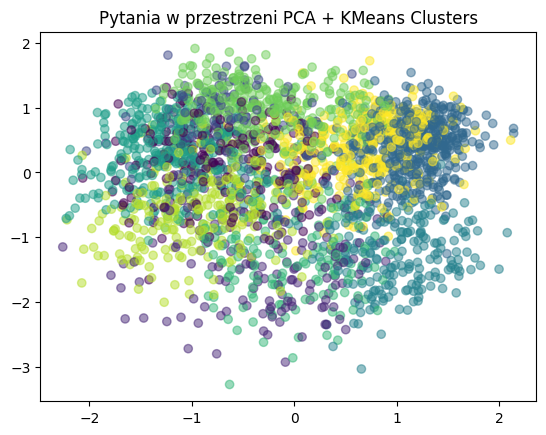

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

reduced_embeddings = pca.fit_transform(embeddings)

variance_explained = sum(pca.explained_variance_ratio_).item()
print(f"{variance_explained = :.2%} - should be around 90%,\n\
~12% is very low quality\n\n")

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, alpha=0.5)
# for i, question in enumerate(questions):
#     plt.annotate(str(i), (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.title("Pytania w przestrzeni PCA + KMeans Clusters")
plt.show()

## Another visualization with TSNE and DBSCAN (both standard tools)

In [45]:
from sklearn.manifold import TSNE

# clustering with TSNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

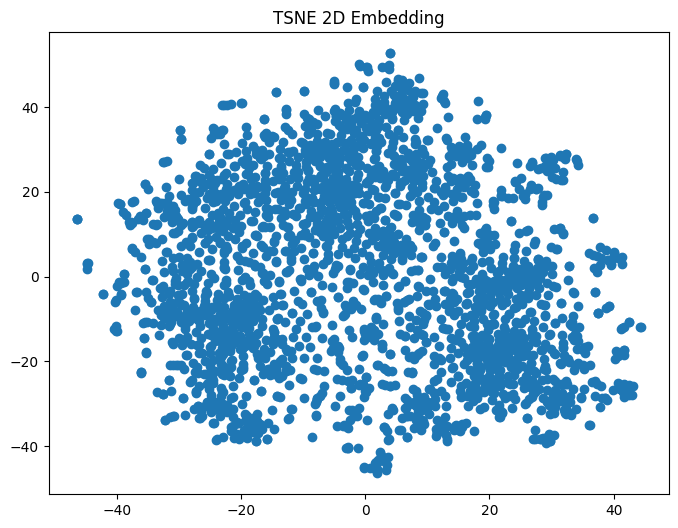

In [47]:
# print TSNE result
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
# for i, question in enumerate(questions):
#     plt.annotate(f"{i}: {question[:30]}...", (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.title("TSNE 2D Embedding")
plt.show()

In [55]:
from sklearn.cluster import DBSCAN
from collections import Counter


dbscan = DBSCAN(eps=5, min_samples=1)  # Dostosuj eps
dbscan_labels = dbscan.fit_predict(embeddings_2d)

c = dict(Counter(dbscan_labels))

print(f"DBSCAN have found {len(c)} clusters:")
print(c)
print("\n\n clusters are highly imbalanced, use then k-means again but ot tsne representation")


# # TSNE with colors of DBSCAN found clusters
# plt.figure(figsize=(8, 6))
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=dbscan_labels, cmap='tab10')
# for i, question in enumerate(questions):
#     plt.annotate(f"{i}: {question[:30]}...", (embeddings_2d[i, 0], embeddings_2d[i, 1]))
# plt.title("TSNE + DBSCAN Clusters")
# plt.show()

# # 6) result
# for question, label in zip(questions, dbscan_labels):
#     print(f"[Cluster {label}] {question}")

DBSCAN have found 5 clusters:
{np.int64(0): 2484, np.int64(1): 6, np.int64(2): 4, np.int64(3): 2, np.int64(4): 3}


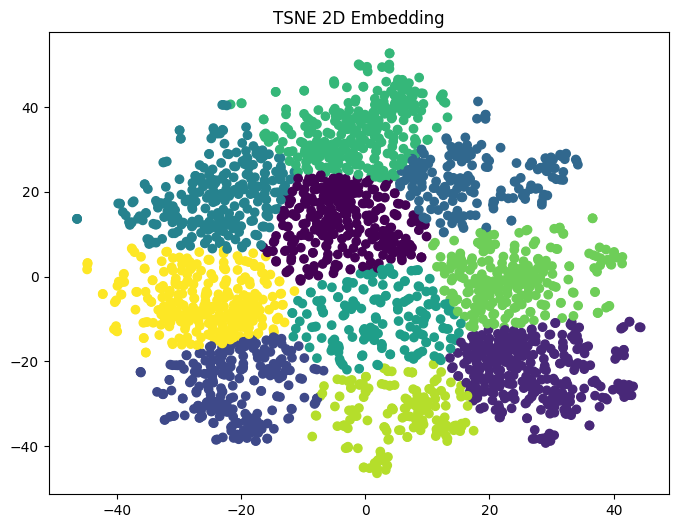

In [56]:
# kmeans again

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings_2d)

# Etkiety klastrów
labels = kmeans.labels_

# print TSNE result
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.title("TSNE 2D Embedding")
plt.show()

In [58]:
# Pokaż, jak pytania zostały przypisane
questions_to_print = 5
for cluster_number in range(num_clusters):
  counter = 0
  for question, label in zip(questions, labels):
    if label == cluster_number:
      print(f"[Cluster {label}] {question}")
      counter += 1
      if counter == questions_to_print:
        print("...")
        break

[Cluster 0] W którym mieście zmarł Sławomir Mrożek?
[Cluster 0] Ku czci której greckiej bogini organizowane były panatenaje?
[Cluster 0] Jak nazywał się Michał Anioł?
[Cluster 0] Jak po staropolsku zwał się okres od Bożego Narodzenia do Trzech Króli?
[Cluster 0] Jak nazywał się podróżnik i żołnierz, który dokonał podboju Madagaskaru?
...
[Cluster 1] Która kawa zawiera alkohol: po turecku czy po irlandzku?
[Cluster 1] Co ma pod stopami Wenus na obrazie Botticellego pt. „Narodziny Wenus”?
[Cluster 1] Do którego warzywa odsyłamy coś, co się do niczego nie nadaje?
[Cluster 1] Jak nazywa się modyfikowany tlenek cyrkonu, imitujący diament?
[Cluster 1] Jakie warzywo jest jednym z głównych składników kopytek?
...
[Cluster 2] Na którym kontynencie leżała Kartagina?
[Cluster 2] Które owady australijskie tworzą ogromne kopce, wysokie na 6 metrów?
[Cluster 2] Częścią którego oceanu jest Morze Czerwone?
[Cluster 2] Nad którym morzem leżą Inflanty?
[Cluster 2] Która rzeka o długości ok. 300 km rozdz

##Similar questions

In [69]:
from sklearn.metrics.pairwise import cosine_similarity


similarities = cosine_similarity(embeddings, embeddings)
np.fill_diagonal(similarities, val=0)  # set self-similarity of question to zero
similarities[:5,:5]

array([[0.        , 0.10809155, 0.33942288, 0.3100394 , 0.22426268],
       [0.10809155, 0.        , 0.13779157, 0.24296   , 0.17021835],
       [0.33942288, 0.13779157, 0.        , 0.38711566, 0.4144085 ],
       [0.3100394 , 0.24296   , 0.38711566, 0.        , 0.26405236],
       [0.22426268, 0.17021835, 0.4144085 , 0.26405236, 0.        ]],
      dtype=float32)

In [93]:
most_similar_idx = np.argmax(similarities, axis=1)
most_similar_question = np.array(questions)[most_similar_idx]
similarity_score = np.max(similarities, axis=1)

for i in range(10):
  print(f"Question: {questions[i]}")
  print(f"Most similar: {most_similar_question[i]}")
  print("\n")

# print(f"Najbardziej podobne pytanie: {most_similar_question}")
# print(f"Podobieństwo: {similarity_score:.3f}")

Question: W którym państwie została ogłoszona „Deklaracja praw człowieka i obywatela”?
Most similar: W którym mieście w USA podpisano Kartę Narodów Zjednoczonych?


Question: Która kawa zawiera alkohol: po turecku czy po irlandzku?
Most similar: Z jakiego państwa pochodzi szampan?


Question: W którym mieście zmarł Sławomir Mrożek?
Most similar: W którym mieście zginął Zbyszek Cybulski?


Question: Jak nazywał się autor powieści „Wierna rzeka”?
Most similar: Jak nazywał się autor powieści „Martwe Dusze”?


Question: W którym polskim mieście wybrzeża znajduje się Fontanna Neptuna?
Most similar: W którym warszawskim parku znajduje się Pałac na Wodzie?


Question: Na którym kontynencie leżała Kartagina?
Most similar: Na jakim kontynencie żyli Goci?


Question: Jak nazywał się reżyser pierwszego polskiego w filmu w 3D: „Bitwa Warszawska”?
Most similar: Jak nazywa się polski reżyser, mąż Jadwigi Barańskiej?


Question: Które owady australijskie tworzą ogromne kopce, wysokie na 6 metrów?
Mos

In [88]:
j

np.str_('W którym mieście w USA podpisano Kartę Narodów Zjednoczonych?')